## Import libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test

## Read simulation files

In [2]:
## Read random baseline simulation results
df_sim_random = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_random_baseline_simulation.csv')
df_sim_random.head()

,participant_id,actual_days,model_intrusive_pings,projected_days,v_model,reduction_rate
0,ambushdollhousegenerous@timestudy_com,100.0,765.84,125.091403,7.658400,0.2
1,anywaymustinesspushiness@timestudy_com,16.0,26.26,20.106626,1.641250,0.2
2,bottledeskworkrequire@timestudy_com,111.0,528.60,139.012486,4.762162,0.2
3,browsingfrisbeepersevere@timestudy_com,78.0,614.48,97.106497,7.877949,0.2
4,buckedstiflestagnant@timestudy_com,207.0,1315.28,258.576881,6.354010,0.2


In [3]:
## Read s1 threshold simulation results
df_sim1_thresholds = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_study_extension_setup1.csv')
df_sim1_thresholds.head()

,participant_id,threshold,actual_days,projected_days,extension_days,v_lazy,v_model,saved_participant
0,ambushdollhousegenerous@timestudy_com,958,100.0,304.13,204.13,9.5800,3.1500,0
1,anywaymustinesspushiness@timestudy_com,33,16.0,21.12,5.12,2.0625,1.5625,0
2,bottledeskworkrequire@timestudy_com,662,111.0,193.37,82.37,5.9640,3.4234,0
3,browsingfrisbeepersevere@timestudy_com,765,78.0,309.17,231.17,9.8077,2.4744,0
4,buckedstiflestagnant@timestudy_com,1643,207.0,365.00,158.00,7.9372,2.8696,1


In [4]:
## Read s2 threshold simulation results
df_sim2_thresholds = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_study_extension_setup2.csv')
df_sim2_thresholds.head()

,participant_id,threshold,actual_days,projected_days,extension_days,v_lazy,v_model,saved_participant
0,ambushdollhousegenerous@timestudy_com,958,100.0,365.0,265.0,9.5800,0.5400,1
1,anywaymustinesspushiness@timestudy_com,33,16.0,52.8,36.8,2.0625,0.6250,0
2,bottledeskworkrequire@timestudy_com,662,111.0,365.0,254.0,5.9640,1.2072,1
3,browsingfrisbeepersevere@timestudy_com,765,78.0,365.0,287.0,9.8077,0.2949,1
4,buckedstiflestagnant@timestudy_com,1643,207.0,365.0,158.0,7.9372,0.6618,1


## Survival analysis

In [5]:
def prepare_survival_dataframe(df_random, df_s1, df_s2):
    """
    Combines simulation results into a long-format DataFrame for statistical testing.
    The 'Actual (Lazy)' group is derived from the 'actual_days' column of the models.
    """
    data_list = []
    
    # 1. First, create the 'Actual (Lazy)' group using Ground Truth (actual_days)
    # We can pull this from any of the three dataframes as it is consistent across all.
    actual_df = pd.DataFrame({
        'duration': df_s1['actual_days'],
        'group': 'Actual (Lazy)',
        # For the withdrawn group, these are all observed events (they actually quit)
        'event': (df_s1['actual_days'] < 365.0).astype(int)
    })
    data_list.append(actual_df)

    # 2. Add the Simulated results (projected_days)
    mapping = {
        'Random (20% Block)': df_random,
        'Setup 1': df_s1,
        'Setup 2': df_s2
    }
    
    for label, df in mapping.items():
        temp_df = pd.DataFrame({
            'duration': df['projected_days'],
            'group': label,
            # Observed = 0 if they survive to 365 (Censored), else 1 (Event)
            'event': (df['projected_days'] < 365.0).astype(int)
        })
        data_list.append(temp_df)
    
    return pd.concat(data_list, ignore_index=True)

In [6]:
df_survival_master = prepare_survival_dataframe(df_sim_random, df_sim1_thresholds, df_sim2_thresholds)

In [7]:
def run_statistical_tests(df_long):
    """
    Performs Omnibus Log-Rank test followed by Pairwise Post-Hoc comparisons.
    """
    print("\n" + "="*60)
    print("      SURVIVAL STATISTICS: OMNIBUS & POST-HOC")
    print("="*60)

    # 1. Omnibus Test (Multivariate Log-Rank)
    results_omnibus = multivariate_logrank_test(
        df_long['duration'], 
        df_long['group'], 
        df_long['event']
    )
    
    print(f"OMNIBUS LOG-RANK TEST")
    print(f"p-value: {results_omnibus.p_value:.2e}")
    print(f"Test Statistic: {results_omnibus.test_statistic:.4f}")
    
    if results_omnibus.p_value < 0.05:
        print("\nRESULT: Significant difference detected between groups.")
        print("Proceeding to Pairwise Post-Hoc comparisons...")
        
        # 2. Pairwise Post-Hoc (Log-Rank)
        results_pairwise = pairwise_logrank_test(
            df_long['duration'], 
            df_long['group'], 
            df_long['event']
        )
        
        print("\nPAIRWISE LOG-RANK SUMMARY:")
        print(results_pairwise.summary[['test_statistic', 'p', '-log2(p)']])
    else:
        print("\nRESULT: No significant difference detected across groups.")

    print("="*60 + "\n")

In [8]:
run_statistical_tests(df_survival_master)


      SURVIVAL STATISTICS: OMNIBUS & POST-HOC
OMNIBUS LOG-RANK TEST
p-value: 2.22e-26
Test Statistic: 122.5099

RESULT: Significant difference detected between groups.
Proceeding to Pairwise Post-Hoc comparisons...

PAIRWISE LOG-RANK SUMMARY:
                                       test_statistic             p   -log2(p)
Actual (Lazy)      Random (20% Block)        4.020815  4.494198e-02   4.475792
                   Setup 1                  42.943971  5.633024e-11  34.047299
                   Setup 2                  92.445908  6.919031e-22  70.291848
Random (20% Block) Setup 1                  25.756594  3.873014e-07  21.300040
                   Setup 2                  71.724488  2.474426e-17  55.165684
Setup 1            Setup 2                  17.114746  3.518804e-05  14.794555



In [11]:
def plot_survival_curves(df_long):
    """
    Generates a high-quality Kaplan-Meier plot with all four conditions.
    """
    plt.figure(figsize=(12, 8))
    kmf = KaplanMeierFitter()
    
    # Define styling for visual clarity
    styles = {
        'Actual (Lazy)': {'color': 'black', 'ls': '--', 'alpha': 0.8},
        'Random (20% Block)': {'color': 'red', 'ls': ':', 'alpha': 0.7},
        'Setup 1': {'color': 'royalblue', 'ls': '-', 'alpha': 0.9},
        'Setup 2': {'color': 'forestgreen', 'ls': '-', 'alpha': 1.0}
    }

    # Iterate through unique groups to fit and plot
    for group_name in ['Actual (Lazy)', 'Random (20% Block)', 'Setup 1', 'Setup 2']:
        if group_name not in df_long['group'].unique():
            continue
            
        mask = df_long['group'] == group_name
        
        kmf.fit(
            durations=df_long.loc[mask, 'duration'],
            event_observed=df_long.loc[mask, 'event'],
            label=group_name
        )
        
        kmf.plot_survival_function(
            ci_show=True, 
            color=styles[group_name]['color'],
            linestyle=styles[group_name]['ls'],
            alpha=styles[group_name]['alpha'],
            lw=2.5 if 'Setup' in group_name else 1.5
        )

    # Chart Formatting
    plt.title("Counterfactual Survival Analysis: Impact of Intelligent Burden Reduction", fontsize=15, pad=20)
    plt.xlabel("Days in Study (Observation Period)", fontsize=13)
    plt.ylabel("Probability of Participant Retention", fontsize=13)
    plt.ylim(0, 1.05)
    plt.xlim(0, 370)
    plt.axvline(365, color='red', linestyle='--', alpha=0.3, label='Study End (Day 365)')
    
    plt.grid(True, which='major', linestyle='-', alpha=0.2)
    plt.legend(loc='lower left', fontsize=11, frameon=True)
    
    plt.tight_layout()
    plt.show()

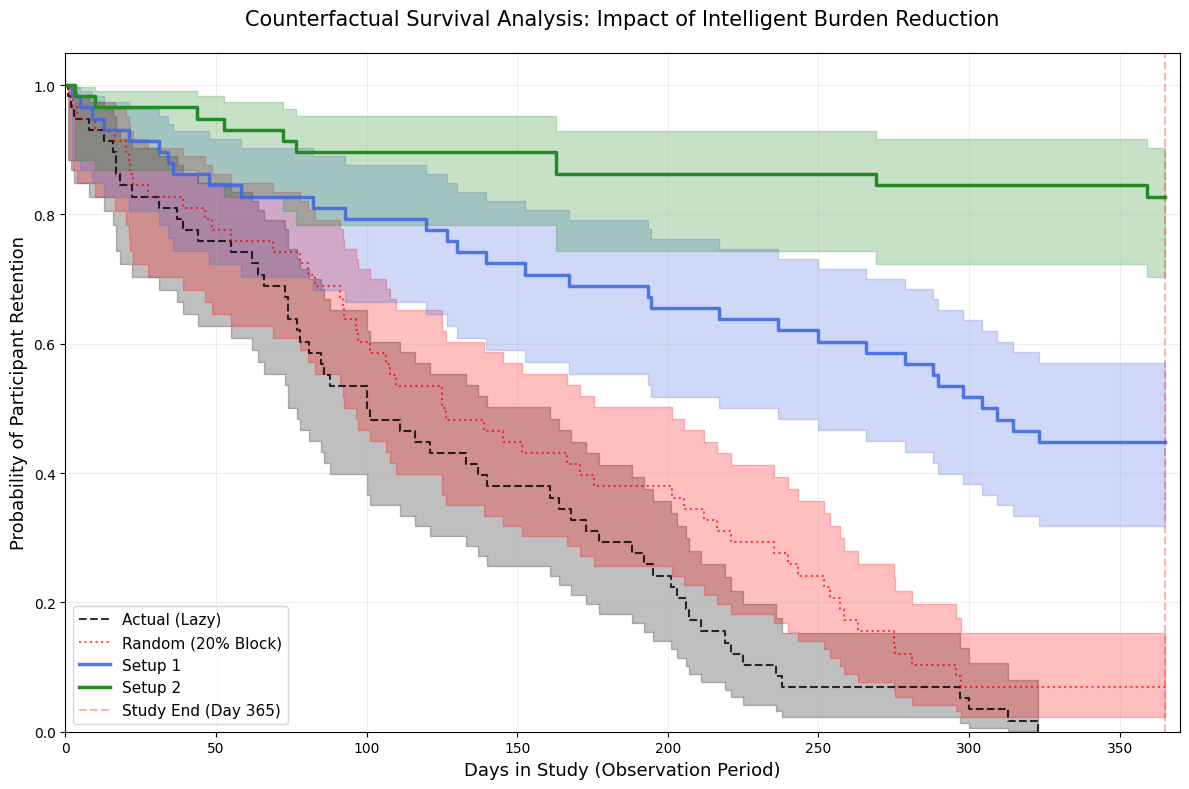

In [12]:
plot_survival_curves(df_survival_master)

In [23]:
def plot_retention_distributions(df_long):
    """
    Generates a 2x2 grid of density plots for each condition,
    highlighting the mean with a dashed line and text label on the line.
    All subplots share the same x and y axes for comparability.
    """
    # Define order and palette
    order = ['Actual (Lazy)', 'Random (20% Block)', 'Setup 1', 'Setup 2']
    palette = {
        'Actual (Lazy)': 'black',
        'Random (20% Block)': 'red',
        'Setup 1': 'royalblue',
        'Setup 2': 'forestgreen'
    }

    # Added sharey=True to ensure uniform y-axis scaling across the grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, group in enumerate(order):
        ax = axes[i]
        if group not in df_long['group'].unique():
            continue
            
        data = df_long[df_long['group'] == group]['duration']
        mean_val = data.mean()
        
        # Plot Density
        sns.kdeplot(
            data=data, 
            ax=ax,
            color=palette[group],
            fill=True,
            alpha=0.3,
            linewidth=2,
            bw_adjust=0.5
        )
        
        # Highlight mean with a dashed line
        ax.axvline(x=mean_val, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
        
        # Write mean on the line
        # Use a relative position based on the current axis view
        y_limit = ax.get_ylim()[1]
        ax.text(
            mean_val + 2, 
            y_limit * 0.7, 
            f'Mean: {mean_val:.1f}d', 
            color='black', 
            fontweight='bold',
            rotation=0,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
        )

        # Study End Reference
        ax.axvline(365, color='red', linestyle='-', alpha=0.2)
        
        # Subplot Formatting
        ax.set_title(f"Condition: {group}", fontsize=13, fontweight='bold')
        ax.set_ylabel("Density" if i % 2 == 0 else "")
        ax.set_xlabel("Days in Study" if i >= 2 else "")
        ax.set_xlim(0, 400)
        ax.grid(True, linestyle=':', alpha=0.4)

    plt.suptitle("Retention Density Distribution Analysis", fontsize=17, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

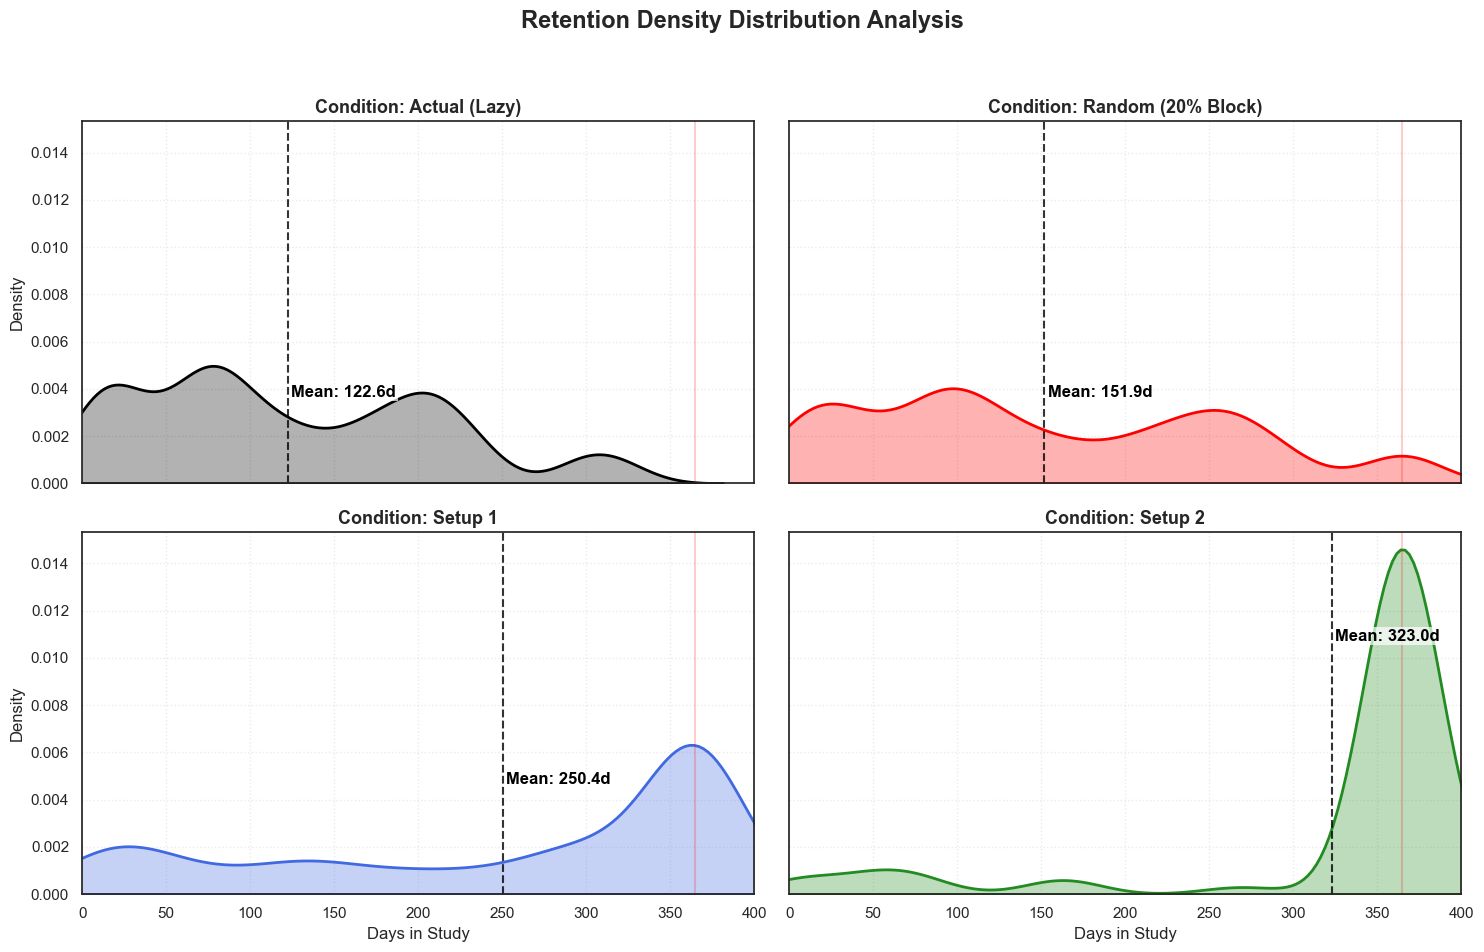

In [24]:
plot_retention_distributions(df_survival_master)